In [1]:
# Import libraries
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
import json
from typing import Union
import numpy as np
from disagreement import Disagreement
import seaborn as sns

In [4]:
! ls /storage/scratch/e17-fyp-xai/projects/mad/e17-4yp-using-machine-learning-in-high-stake-settings/code/model_outputs_12/

lime  shap  treeshap  xai_results


In [25]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 622.5 kB/s eta 0:00:0000:0100:01


In [2]:
from compactor.MaxNonActivatedCompactor import MaxNonActivatedCompactor
from compactor.ActivatedCompactor import ActivatedCompactor
from compactor.MaxCompactor import MaxCompactor

In [3]:
# Set path for RF
main_path = "/storage/scratch/e17-fyp-xai/projects/e17-4yp-using-machine-learning-in-high-stake-settings/code/"

#json_file_path = "/storage/scratch/e17-fyp-xai/projects/mad/e17-4yp-using-machine-learning-in-high-stake-settings/code/model_outputs_12/xai_results/all_exp.json" 
json_file_path = main_path + "model_outputs_13/xai_results/all_exp.json"
model_path = main_path + "model_outputs/artifacts/random_forest_t_300_md_10/" + "random_forest_t_300_md_10_fold_1_2016-01-07.pkl"
predictions_file_path = main_path + "model_outputs/artifacts/random_forest_t_300_md_10/test_prediction_fold_1_2016-01-07.csv"
processed_data_path = main_path + "processed_data/processed_final_data_latest.csv"
fold = 'fold0'

image_save_path = "Images_XAI_Fold_1_2016-01-07/RF_Baseline_6000/Matrices_Baseline"

In [4]:
categorical_cols = ["Project Type", "Project Subject Category Tree", "Project Subject Subcategory Tree",
                    "Project Grade Level Category", "Project Resource Category", "School Metro Type",
                    "School State", "Teacher Prefix",
                    ]

In [5]:
# Function to save images
def save_image(caption, path):
    set_path = f'{path}/{caption}.png'
    plt.savefig(set_path)

In [6]:
# Read dataframe to get actual label and for the categorical columns
processed = pd.read_csv(processed_data_path)
processed.columns

Index(['Unnamed: 0', 'Project ID', 'Project Posted Date', 'Project Type',
       'Project Posted Month', 'Project Subject Category Tree', 'Project Cost',
       'Project Subject Subcategory Tree', 'Project Grade Level Category',
       'Project Resource Category', 'School Metro Type',
       'School Percentage Free Lunch', 'School State', 'Teacher Prefix',
       'Teacher Project Posted Sequence', 'Label', 'Teacher Success Rate',
       'Teacher Success Rate Imputed', 'School City Success Rate',
       'School City Success Rate Imputed', 'School Success Rate',
       'School Success Rate Imputed', 'School County Success Rate',
       'School County Success Rate Imputed', 'Project Count in State'],
      dtype='object')

In [7]:
# Load explanations
explanations = json.load(open(json_file_path))

In [8]:
print(len(explanations[fold]['lime']['top'].keys()))

3000


In [9]:
# Calculate the average agreement values
def find_avg_disagreement(explanations_1, explanations_2, both_local, k, features_F, raw_data=None, method=None):
    
    # explanations_1 is always local
    # explanations_2 can either be local or global
    
    disagreement_mean = {'feature_agreement': 0.0,
                         'rank_agreement': 0.0,
                         'sign_agreement': 0.0,
                         'signed_rank_agreement': 0.0
                        }
    disagreement_calc = None

    for project_id in explanations_1.keys():
        # Initialize disagreement calculation
        if both_local:
            disagreement_calc = Disagreement(explanations_1[project_id], explanations_2[project_id])
        else:
            disagreement_calc = Disagreement(explanations_2, explanations_1[project_id])

        # Select compactor
        if method=="max":
            max_compactor = MaxCompactor(categorical_cols)
            disagreement_calc.compact_features(max_compactor)
            
        elif method == "activated" and raw_data is not None:
            activated_features = {}
            for feature in categorical_cols:
                activated_features[feature] = f"{feature}_{raw_data[raw_data['Project ID'] == project_id ][feature].values[0]}"
            activated_compactor = ActivatedCompactor(activated_features)
            disagreement_calc.compact_features(activated_compactor)
            
        elif method == "maxnonactivated" and raw_data is not None:
            activated_features = {}
            for feature in categorical_cols:
                activated_features[feature] = f"{feature}_{raw_data[raw_data['Project ID'] == project_id ][feature].values[0]}"
            max_non_activated_compactor = MaxNonActivatedCompactor(activated_features)
            disagreement_calc.compact_features(max_non_activated_compactor)

        # Get disagreement
        disagreement_levels = disagreement_calc.get_disagreement(k, features_F)

        for key in list(disagreement_mean.keys()):
            if disagreement_levels[key] == None:
                raise ValueError(f"The value for key '{key}' in disagreement_mean is None.")
            disagreement_mean[key] += disagreement_levels[key]

    for key in list(disagreement_mean.keys()):
        disagreement_mean[key] = round(disagreement_mean[key] / len(explanations_1.keys()),3)

    
    return disagreement_mean

In [10]:
# Function to load the pickle file and return the feature importances
def load_model_and_feat(pkl_model_path, model_name):
  # Load the model
  #model = pickle.load(open(pkl_model_path, 'rb'))
  with open(pkl_model_path, "rb") as file_handle:
    model = pickle.load(file_handle)

  if model_name == 'logreg':
    # Load the feature importance array
    importance = model.coef_[0]
  else:
    importance = model.feature_importances_
  # Get the feature names
  feat_names = model.feature_names_in_

  return importance, feat_names


# Function to sort features and output
def sort_features(importance, feat_names):
    # Create df and sort
    df = pd.DataFrame({"Feature": feat_names, "Importance": importance})
    #df_sorted = df.sort_values("Importance", ascending=False)
    df_sorted = df.reindex(df.Importance.abs().sort_values(ascending=False).index)
    return df_sorted

In [ ]:
!pip install scikit-learn==1.3.0

In [11]:
# Load model
global_importance, feat_names = load_model_and_feat(model_path, "rf")
print(global_importance, feat_names)
global_explanation_feat = sort_features(global_importance, feat_names)
global_explanation_feat.values

[3.61000484e-02 2.59972053e-01 2.38932983e-02 3.65925642e-02
 4.09273999e-02 1.43449148e-02 6.23434576e-02 2.28542013e-03
 9.44354758e-02 6.87659534e-03 5.05636855e-02 1.38445586e-03
 2.51400872e-02 4.76777048e-03 1.88462059e-03 1.62638077e-03
 8.00286977e-04 4.04883136e-04 2.63697138e-04 8.12679251e-04
 5.28259431e-04 4.40797247e-04 6.59705333e-04 0.00000000e+00
 1.06799391e-03 1.03223494e-04 1.45426193e-05 2.26682129e-04
 8.64224050e-05 6.91804929e-05 3.43207484e-04 0.00000000e+00
 6.22417150e-04 4.55330641e-05 0.00000000e+00 4.58919562e-04
 2.35046294e-04 5.28531454e-04 2.30476796e-04 0.00000000e+00
 1.92891789e-03 2.48161773e-04 3.21397865e-05 5.62327971e-04
 1.95860687e-03 1.06183602e-03 1.27164498e-03 0.00000000e+00
 2.13978925e-03 5.83565412e-04 1.48677643e-04 4.47384205e-04
 8.18152591e-04 5.36978820e-04 8.28936721e-04 0.00000000e+00
 1.37420192e-03 3.04535252e-06 1.36462800e-05 4.21279728e-05
 1.11981950e-04 0.00000000e+00 9.99050899e-04 5.53649271e-05
 2.32792537e-04 0.000000

array([['Project Cost', 0.2599720532503212],
       ['School Success Rate', 0.09443547578970575],
       ['School City Success Rate', 0.06234345759559309],
       ...,
       ['Project Subject Subcategory Tree_Financial Literacy, Warmth, Care & Hunger',
        0.0],
       ['Project Subject Subcategory Tree_Foreign Languages, Gym & Fitness',
        0.0],
       ['Project Subject Subcategory Tree_Extracurricular, Nutrition Education',
        0.0]], dtype=object)

In [12]:
# Calculate disgreement mean for LIME vs SHAP
# Dictionary for 1000 LIME explanations
lime_explanations = explanations[fold]["lime"]["top"] | explanations[fold]["lime"]["bottom"]
# Dictionary for 1000 SHAP explanations
treeshap_explanations = explanations[fold]["treeshap"]["top"] | explanations[fold]["treeshap"]["bottom"]
print(len(treeshap_explanations.keys()))


6000


Top 20% of the features

In [13]:
# Get average disagreement for LIME vs SHAP
avg_disagreement_lvs_20 = find_avg_disagreement(lime_explanations, treeshap_explanations, True, 115, None)
print(avg_disagreement_lvs_20)
avg_disagreement_lvs_max_20 = find_avg_disagreement(lime_explanations, treeshap_explanations, True, 5, None, processed, "max")
print(avg_disagreement_lvs_max_20)
avg_disagreement_lvs_act_20 = find_avg_disagreement(lime_explanations, treeshap_explanations, True, 5, None, processed, "activated")
print(avg_disagreement_lvs_act_20)
avg_disagreement_lvs_maxnonact_20 = find_avg_disagreement(lime_explanations, treeshap_explanations, True, 5, None, processed, "maxnonactivated")
print(avg_disagreement_lvs_maxnonact_20)

{'feature_agreement': 0.196, 'rank_agreement': 0.005, 'sign_agreement': 0.176, 'signed_rank_agreement': 0.004}
{'feature_agreement': 0.431, 'rank_agreement': 0.122, 'sign_agreement': 0.376, 'signed_rank_agreement': 0.11}
{'feature_agreement': 0.752, 'rank_agreement': 0.375, 'sign_agreement': 0.739, 'signed_rank_agreement': 0.374}
{'feature_agreement': 0.318, 'rank_agreement': 0.104, 'sign_agreement': 0.306, 'signed_rank_agreement': 0.101}


In [14]:
# Get average disagreement for LIME vs global
avg_disagreement_lvg_20 = find_avg_disagreement(lime_explanations, global_explanation_feat.values, False, 115, None)
print(avg_disagreement_lvg_20)
avg_disagreement_lvg_max_20 = find_avg_disagreement(lime_explanations, global_explanation_feat.values, False, 5, None, processed, "max")
print(avg_disagreement_lvg_max_20)
avg_disagreement_lvg_act_20 = find_avg_disagreement(lime_explanations, global_explanation_feat.values, False, 5, None, processed, "activated")
print(avg_disagreement_lvg_act_20)
avg_disagreement_lvg_maxnonact_20 = find_avg_disagreement(lime_explanations, global_explanation_feat.values, False, 5, None, processed, "maxnonactivated")
print(avg_disagreement_lvg_maxnonact_20)

{'feature_agreement': 0.227, 'rank_agreement': 0.005, 'sign_agreement': 0.104, 'signed_rank_agreement': 0.003}
{'feature_agreement': 0.377, 'rank_agreement': 0.12, 'sign_agreement': 0.121, 'signed_rank_agreement': 0.074}
{'feature_agreement': 0.68, 'rank_agreement': 0.322, 'sign_agreement': 0.431, 'signed_rank_agreement': 0.151}
{'feature_agreement': 0.341, 'rank_agreement': 0.104, 'sign_agreement': 0.084, 'signed_rank_agreement': 0.057}


In [15]:
# Get average disagreement for TreeSHAP vs global
avg_disagreement_svg_20 = find_avg_disagreement(treeshap_explanations, global_explanation_feat.values, False, 115, None)
print(avg_disagreement_svg_20)
avg_disagreement_svg_max_20 = find_avg_disagreement(treeshap_explanations, global_explanation_feat.values, False, 5, None, processed, "max")
print(avg_disagreement_svg_max_20)
avg_disagreement_svg_act_20 = find_avg_disagreement(treeshap_explanations, global_explanation_feat.values, False, 5, None, processed, "activated")
print(avg_disagreement_svg_act_20)
avg_disagreement_svg_maxnonact_20 = find_avg_disagreement(treeshap_explanations, global_explanation_feat.values, False, 5, None, processed, "maxnonactivated")
print(avg_disagreement_svg_maxnonact_20)

{'feature_agreement': 0.758, 'rank_agreement': 0.033, 'sign_agreement': 0.3, 'signed_rank_agreement': 0.016}
{'feature_agreement': 0.723, 'rank_agreement': 0.293, 'sign_agreement': 0.407, 'signed_rank_agreement': 0.147}
{'feature_agreement': 0.693, 'rank_agreement': 0.28, 'sign_agreement': 0.444, 'signed_rank_agreement': 0.159}
{'feature_agreement': 0.74, 'rank_agreement': 0.389, 'sign_agreement': 0.397, 'signed_rank_agreement': 0.215}


Top 10% of the features

In [16]:
# Get average disagreement for LIME vs SHAP
avg_disagreement_lvs_10 = find_avg_disagreement(lime_explanations, treeshap_explanations, True, 58, None)
print(avg_disagreement_lvs_10)
avg_disagreement_lvs_max_10 = find_avg_disagreement(lime_explanations, treeshap_explanations, True, 2, None, processed, "max")
print(avg_disagreement_lvs_max_10)
avg_disagreement_lvs_act_10 = find_avg_disagreement(lime_explanations, treeshap_explanations, True, 2, None, processed, "activated")
print(avg_disagreement_lvs_act_10)
avg_disagreement_lvs_maxnonact_10 = find_avg_disagreement(lime_explanations, treeshap_explanations, True, 2, None, processed, "maxnonactivated")
print(avg_disagreement_lvs_maxnonact_10)

{'feature_agreement': 0.185, 'rank_agreement': 0.008, 'sign_agreement': 0.182, 'signed_rank_agreement': 0.008}
{'feature_agreement': 0.306, 'rank_agreement': 0.22, 'sign_agreement': 0.284, 'signed_rank_agreement': 0.207}
{'feature_agreement': 0.747, 'rank_agreement': 0.611, 'sign_agreement': 0.743, 'signed_rank_agreement': 0.609}
{'feature_agreement': 0.244, 'rank_agreement': 0.186, 'sign_agreement': 0.244, 'signed_rank_agreement': 0.186}


In [17]:
# Get average disagreement for LIME vs global
avg_disagreement_lvg_10 = find_avg_disagreement(lime_explanations, global_explanation_feat.values, False, 58, None)
print(avg_disagreement_lvg_10)
avg_disagreement_lvg_max_10 = find_avg_disagreement(lime_explanations, global_explanation_feat.values, False, 2, None, processed, "max")
print(avg_disagreement_lvg_max_10)
avg_disagreement_lvg_act_10 = find_avg_disagreement(lime_explanations, global_explanation_feat.values, False, 2, None, processed, "activated")
print(avg_disagreement_lvg_act_10)
avg_disagreement_lvg_maxnonact_10 = find_avg_disagreement(lime_explanations, global_explanation_feat.values, False, 2, None, processed, "maxnonactivated")
print(avg_disagreement_lvg_maxnonact_10)

{'feature_agreement': 0.249, 'rank_agreement': 0.009, 'sign_agreement': 0.107, 'signed_rank_agreement': 0.006}
{'feature_agreement': 0.244, 'rank_agreement': 0.19, 'sign_agreement': 0.142, 'signed_rank_agreement': 0.142}
{'feature_agreement': 0.719, 'rank_agreement': 0.636, 'sign_agreement': 0.275, 'signed_rank_agreement': 0.248}
{'feature_agreement': 0.244, 'rank_agreement': 0.19, 'sign_agreement': 0.142, 'signed_rank_agreement': 0.142}


In [18]:
# Get average disagreement for TreeSHAP vs global
avg_disagreement_svg_10 = find_avg_disagreement(treeshap_explanations, global_explanation_feat.values, False, 58, None)
print(avg_disagreement_svg_10)
avg_disagreement_svg_max_10 = find_avg_disagreement(treeshap_explanations, global_explanation_feat.values, False, 2, None, processed, "max")
print(avg_disagreement_svg_max_10)
avg_disagreement_svg_act_10 = find_avg_disagreement(treeshap_explanations, global_explanation_feat.values, False, 2, None, processed, "activated")
print(avg_disagreement_svg_act_10)
avg_disagreement_svg_maxnonact_10 = find_avg_disagreement(treeshap_explanations, global_explanation_feat.values, False, 2, None, processed, "maxnonactivated")
print(avg_disagreement_svg_maxnonact_10)

{'feature_agreement': 0.779, 'rank_agreement': 0.056, 'sign_agreement': 0.365, 'signed_rank_agreement': 0.028}
{'feature_agreement': 0.637, 'rank_agreement': 0.489, 'sign_agreement': 0.278, 'signed_rank_agreement': 0.238}
{'feature_agreement': 0.637, 'rank_agreement': 0.489, 'sign_agreement': 0.278, 'signed_rank_agreement': 0.238}
{'feature_agreement': 0.776, 'rank_agreement': 0.609, 'sign_agreement': 0.397, 'signed_rank_agreement': 0.338}


Visualize

In [19]:
# Generate matrices
def generate_matrix_image_for_one(eval_metric:str, k:int, compactor:str, dict_list:list, name_list=["LIME", "TreeSHAP", "Global"]):

    num = len(name_list)
    matrix = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

    for i in range(num):
      for j in range(num):
        if i != j:
          matrix[i][j] = dict_list[i+j-1][eval_metric]
        else:
          matrix[i][j] = 1

    ax = sns.heatmap(matrix, annot=True, xticklabels=name_list, yticklabels=name_list)
    ax.xaxis.tick_top()
    ax.set_title(f"{eval_metric} for k={k} with {compactor} compactor")

    return matrix, ax

In [20]:
# Generate matrices
def generate_matrix_image(eval_metrics:list, k_list:list, compactor:str, dict_list, caption, name_list=["LIME", "TreeSHAP", "Global"]):

    num = len(name_list)
    k_len = len(k_list)
    matrix = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
    ax_objects = []
    fig, ax = plt.subplots(4, k_len, dpi=300, layout='tight')
    fontsize = 6

    for k in range(k_len):
      #print(f'{k}----------------')
      for metric in eval_metrics:
        #print(metric)
        # Generate matrix
        for i in range(num):
          for j in range(num):
            if i != j:
              matrix[i][j] = dict_list[k][i+j-1][metric]
            else:
              matrix[i][j] = 1

        #print(matrix)
        #print(eval_metrics.index(metric))
        sns.heatmap(matrix, annot=True, xticklabels=name_list, yticklabels=name_list, ax=ax[eval_metrics.index(metric), k], fmt=".3f", annot_kws={'fontsize': fontsize}, vmin=0.0, vmax=1.0)
        ax[eval_metrics.index(metric), k].xaxis.tick_top()
        ax[eval_metrics.index(metric), k].set_title(f"{metric} for k={k_list[k]} with {compactor} compactor", fontsize=fontsize)
        plt.rcParams['xtick.labelsize'] = fontsize
        plt.rcParams['ytick.labelsize'] = fontsize
        ax_objects.append(ax[eval_metrics.index(metric), k])
        matrix = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

    #plt.savefig("test.jpg")
    save_image(caption, image_save_path)
    plt.show()

    return


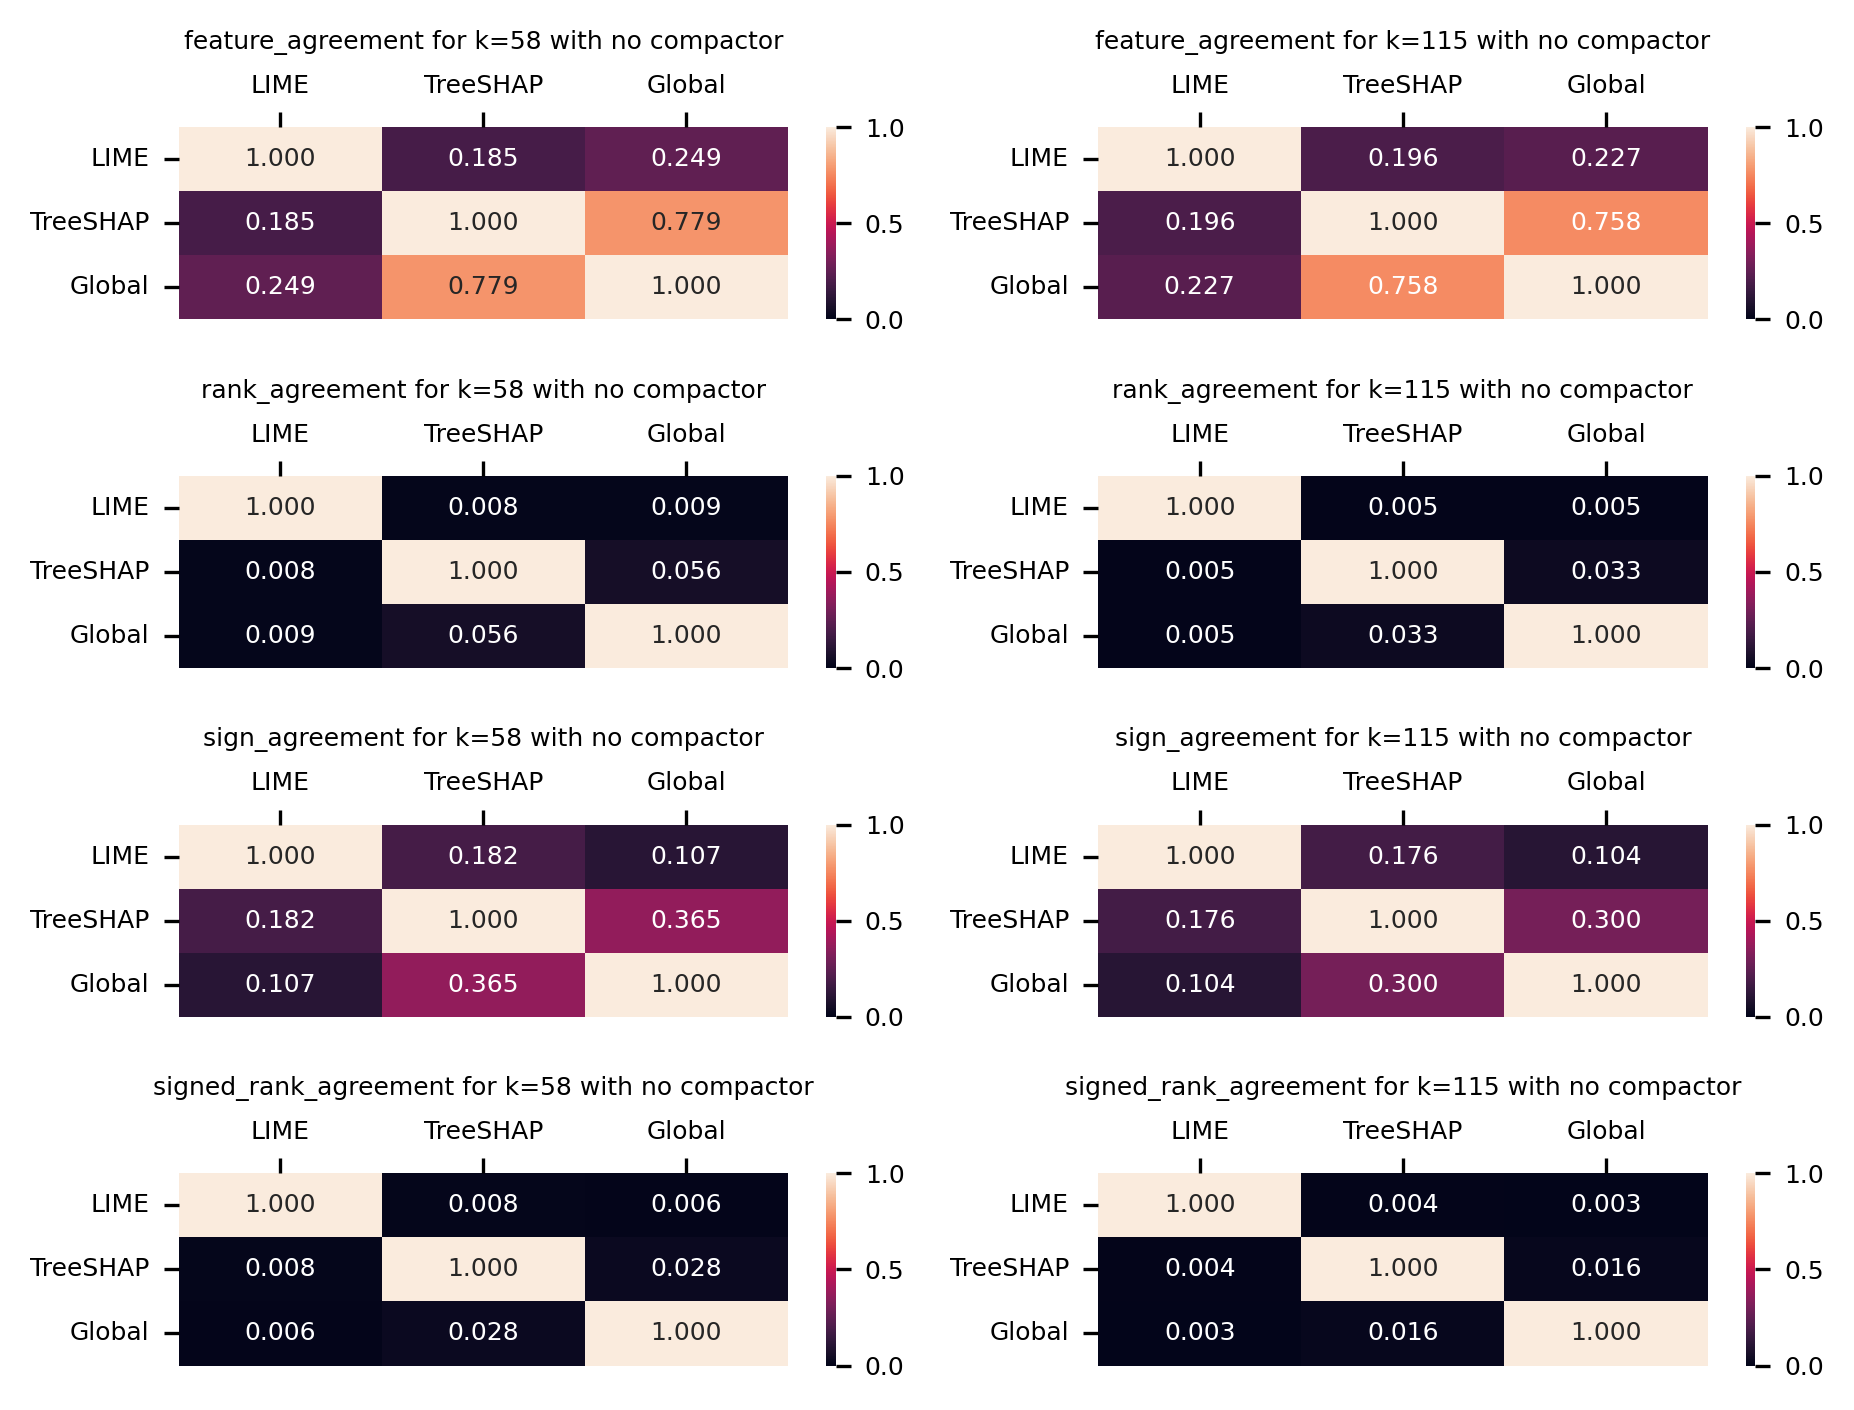

In [23]:
generate_matrix_image(["feature_agreement", "rank_agreement", "sign_agreement", "signed_rank_agreement"], 
                      [58, 115], 
                      "no", 
                      [[avg_disagreement_lvs_10, avg_disagreement_lvg_10, avg_disagreement_svg_10], 
                       [avg_disagreement_lvs_20, avg_disagreement_lvg_20, avg_disagreement_svg_20]], 
                      "rf_baseline_10%_and_20%_no_compactor")

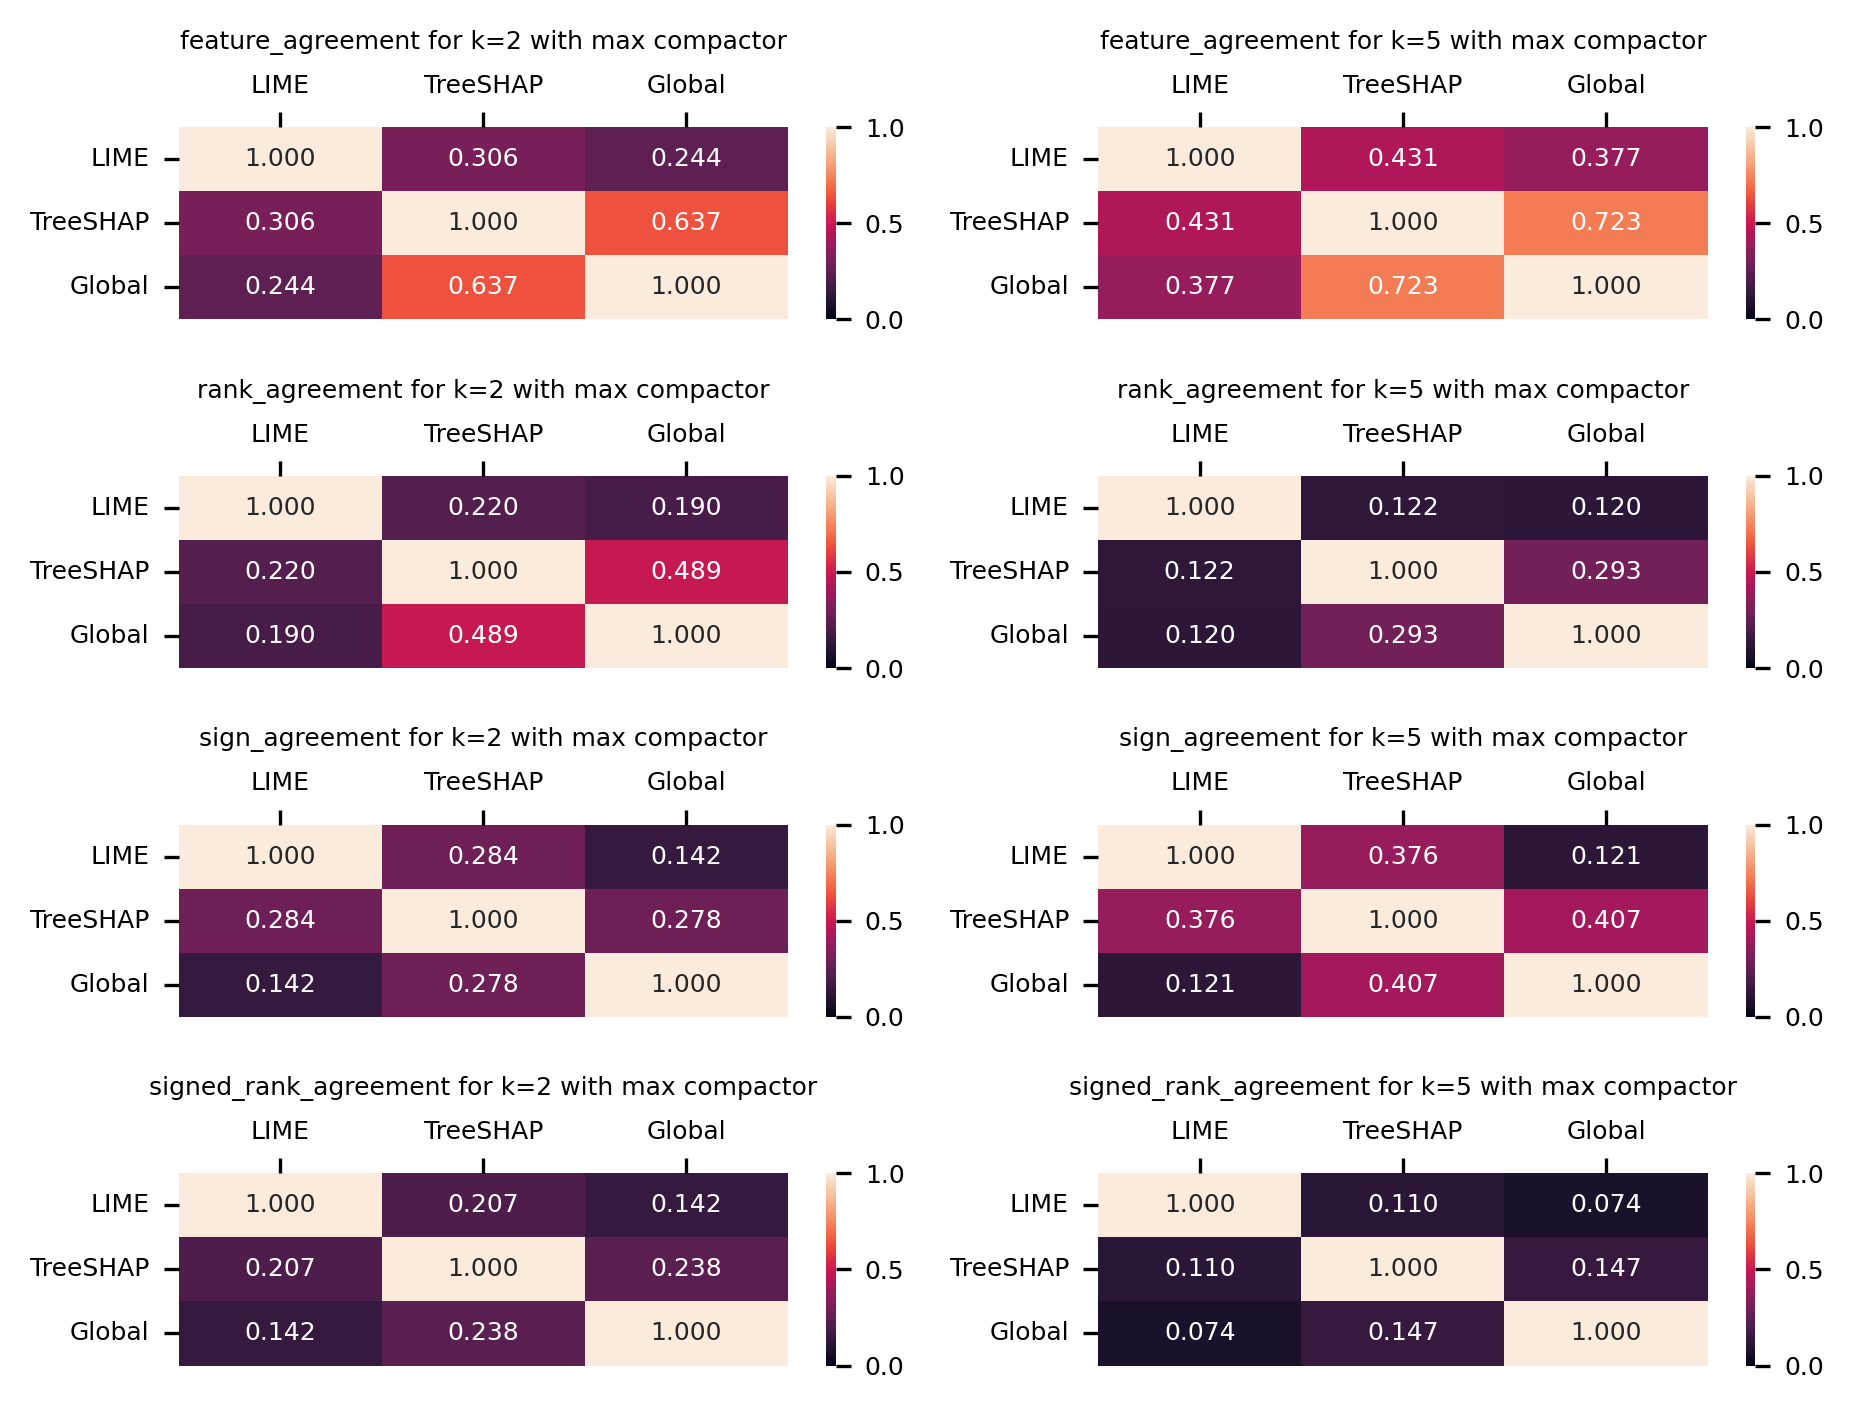

In [22]:
generate_matrix_image(["feature_agreement", "rank_agreement", "sign_agreement", "signed_rank_agreement"], 
                      [2, 5], 
                      "max", 
                      [[avg_disagreement_lvs_max_10, avg_disagreement_lvg_max_10, avg_disagreement_svg_max_10], 
                       [avg_disagreement_lvs_max_20, avg_disagreement_lvg_max_20, avg_disagreement_svg_max_20]], 
                      "rf_baseline_10%_and_20%_max_compactor")

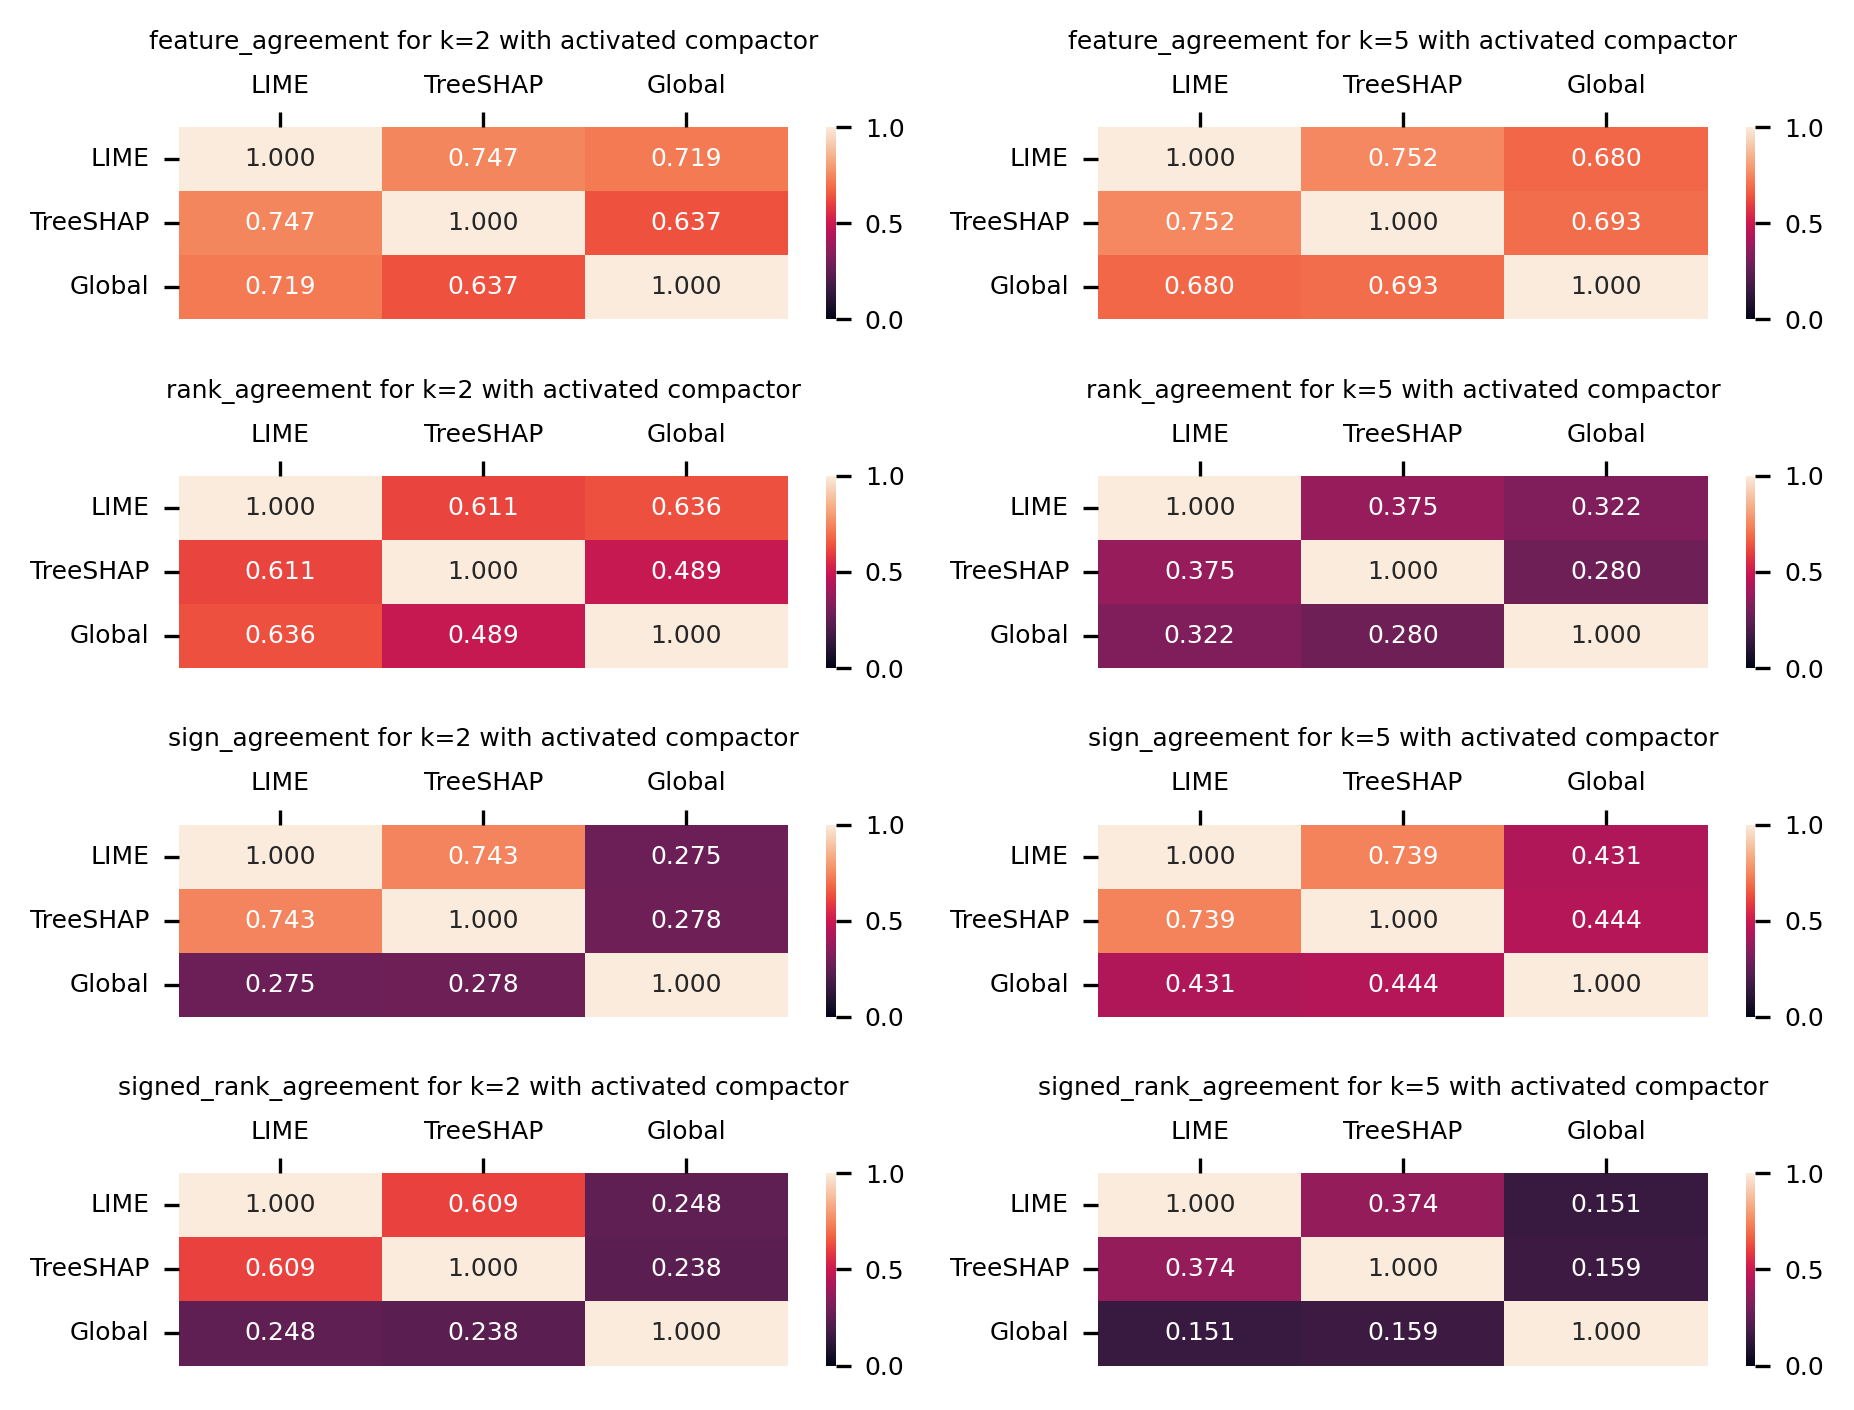

In [25]:
generate_matrix_image(["feature_agreement", "rank_agreement", "sign_agreement", "signed_rank_agreement"], 
                      [2, 5], 
                      "activated", 
                      [[avg_disagreement_lvs_act_10, avg_disagreement_lvg_act_10, avg_disagreement_svg_act_10], 
                       [avg_disagreement_lvs_act_20, avg_disagreement_lvg_act_20, avg_disagreement_svg_act_20]], 
                      "rf_baseline_10%_and_20%_activated_compactor")

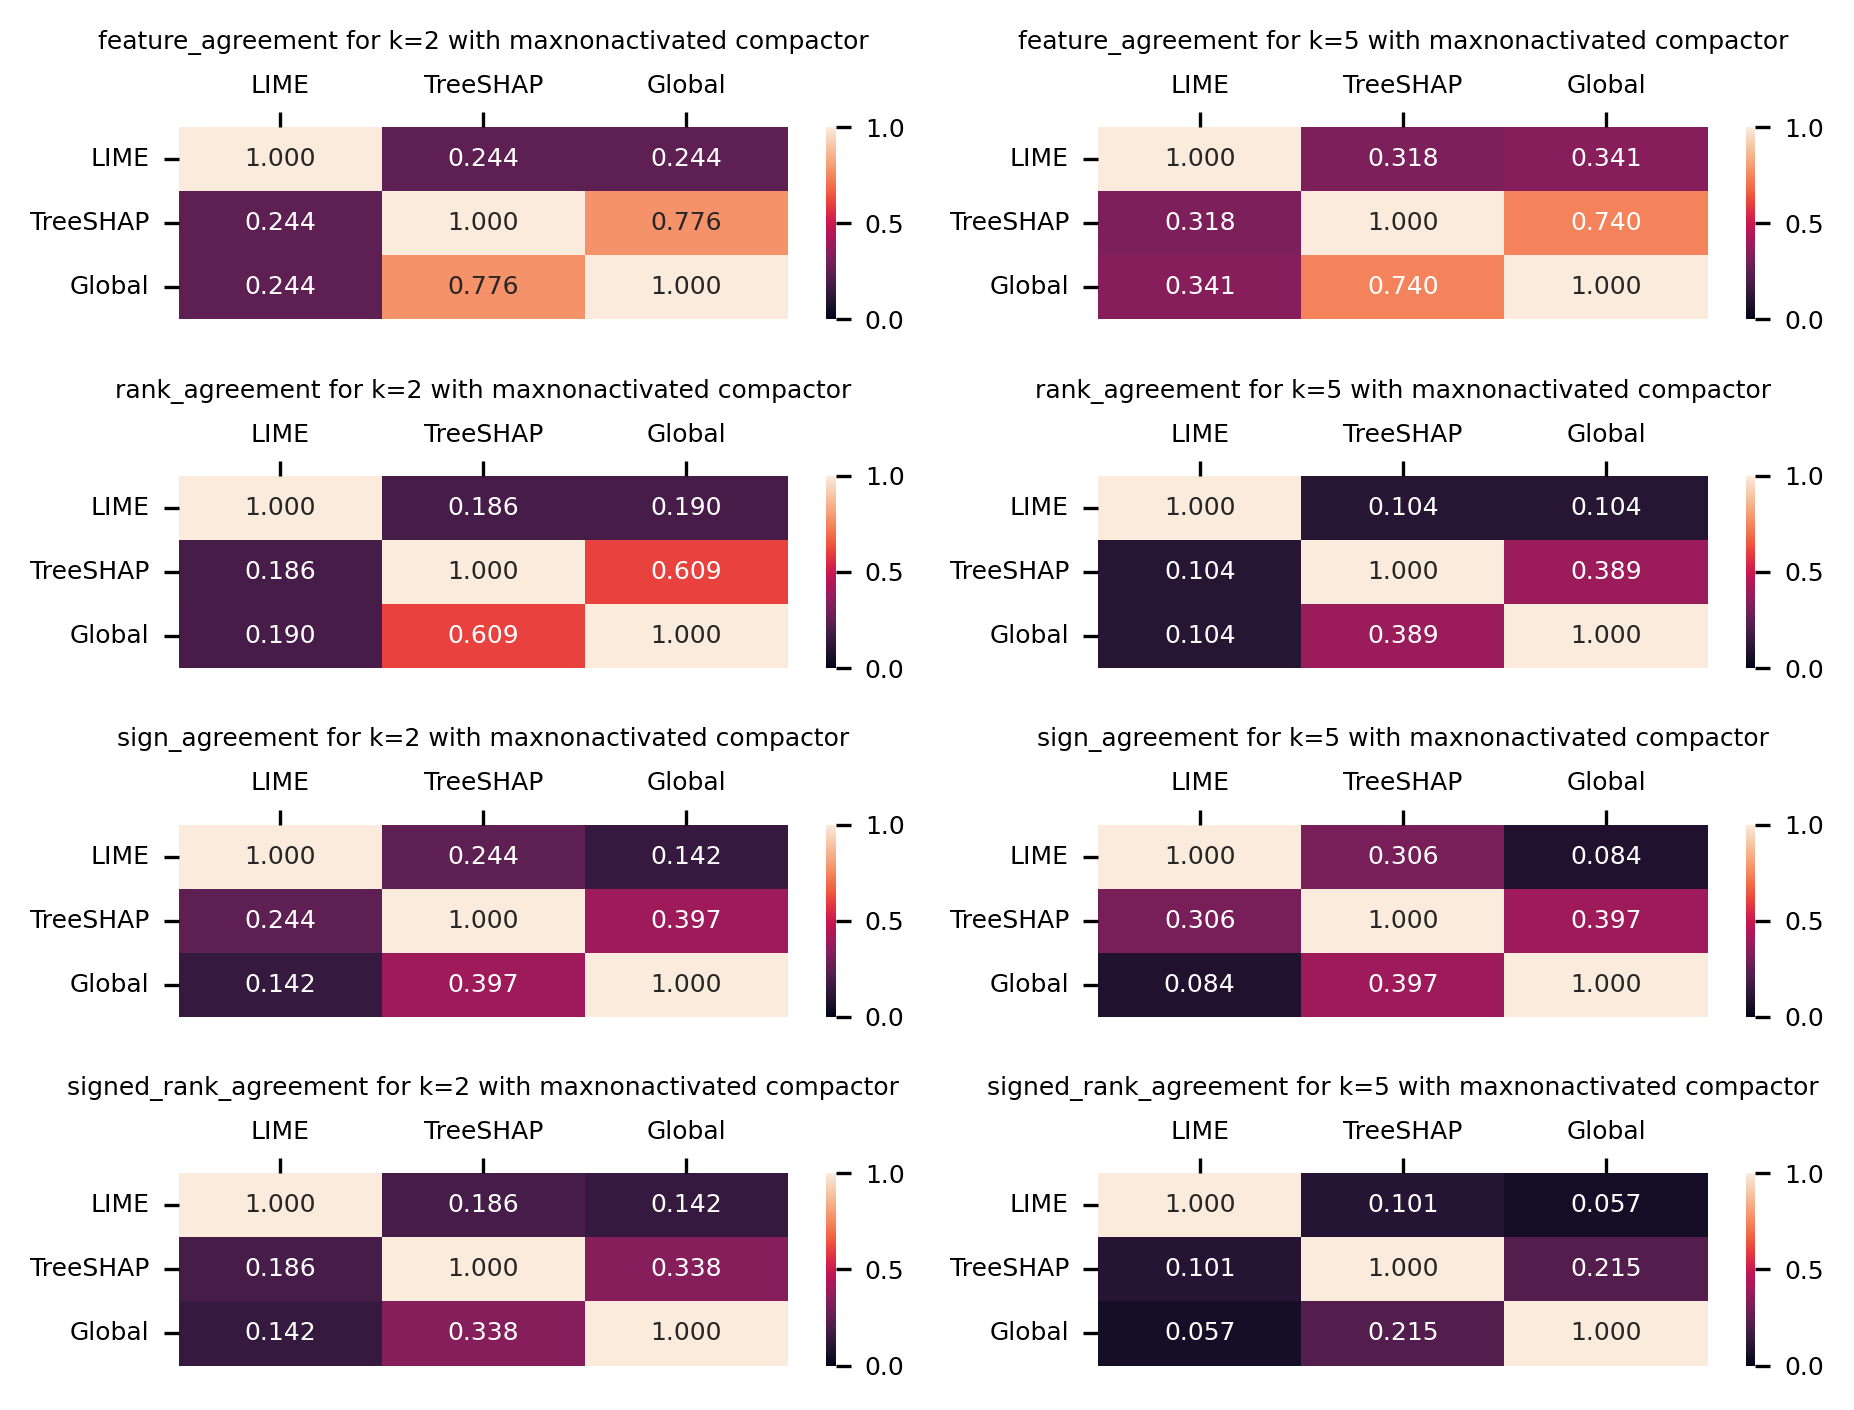

In [26]:
generate_matrix_image(["feature_agreement", "rank_agreement", "sign_agreement", "signed_rank_agreement"], 
                      [2, 5], 
                      "maxnonactivated", 
                      [[avg_disagreement_lvs_maxnonact_10, avg_disagreement_lvg_maxnonact_10, avg_disagreement_svg_maxnonact_10], 
                       [avg_disagreement_lvs_maxnonact_20, avg_disagreement_lvg_maxnonact_20, avg_disagreement_svg_maxnonact_20]], 
                      "rf_baseline_10%_and_20%_maxnonactivated_compactor")